In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py
import scipy.stats as sts

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW
from ATARI.theory.scattering_params import FofE_recursive
from ATARI.theory.scattering_params import gstat
from ATARI.utils.datacontainer import DataContainer
from ATARI.utils.atario import fill_resonance_ladder

from numpy.linalg import inv
from scipy.linalg import block_diag

from scipy.optimize import lsq_linear
from qpsolvers import solve_qp
from scipy.optimize import linprog

import functions as fn 


In [2]:
%matplotlib widget

In [3]:
(2500/0.1)*(50/0.1)

12500000.0

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


(-6.856400836715139, 85.70501045893923)

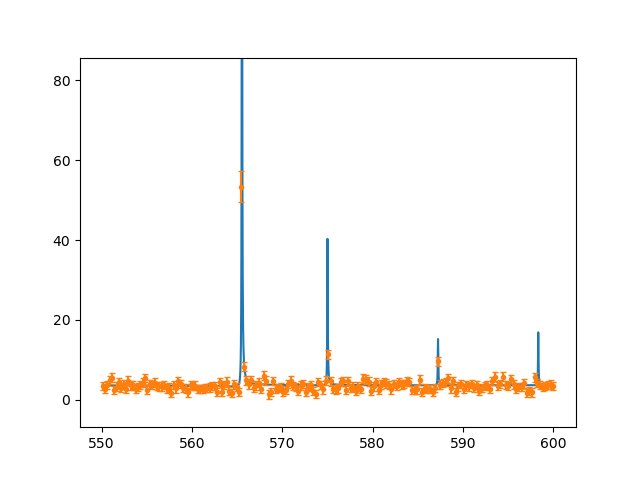

In [4]:

ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})



spin_groups = [ (3.0,1,0)] # , (4.0,1,[0]) ]
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })


E_min_max = [550, 600]
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.0256,   'unc'   :   0}}#,
                        #  'n':  {'val':0.06,     'unc'   :0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)


resonance_ladder = Ta_pair.sample_resonance_ladder(E_min_max, spin_groups, average_parameters, False)
# resonance_ladder = pd.DataFrame({'E':[570], 'J':[3.0], 'chs':[1.0], 'lwave':[0.0], 'J_ID':[1.0], 'gnx2':[100], 'Gg':[750]})
# resonance_ladder = pd.DataFrame({'E':[575], 'J':[3.0], 'chs':[1.0], 'lwave':[0.0], 'J_ID':[1.0], 'gnx2':[5000], 'Gg':[75]})
true, _, _ = SLBW(exp.energy_domain, Ta_pair, resonance_ladder)
df_true = pd.DataFrame({'E':exp.energy_domain, 'theo_trans':np.exp(-exp.redpar.val.n*true)})

exp.run(df_true)

from ATARI.utils.datacontainer import DataContainer
from ATARI.theory.experimental import trans_2_xs

dc = DataContainer()
dc.add_theoretical(Ta_pair, resonance_ladder)
threshold_0T = 1e-2
dc.add_experimental(exp, threshold=threshold_0T)

max_xs, _ = trans_2_xs(threshold_0T, dc.n)

figure()
plot(dc.pw_fine.E, dc.pw_fine.theo_xs)
errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=dc.pw_exp.exp_xs_unc, fmt='.', capsize=2)
ylim([-max_xs*.1, max_xs*1.25])


## Full feature bank and unconstrained solve

In [5]:
# Gts = []
# for i in range(1000):
#     resonance_ladder = Ta_pair.sample_resonance_ladder(E_min_max, spin_groups, average_parameters, False)
#     dc.add_theoretical(Ta_pair, resonance_ladder)
#     Gts.extend(np.array(resonance_ladder.Gt))

# print(min(Gts))
# print(max(Gts))

In [6]:
average_parameters.loc[:,['Gn']] = average_parameters['gn2']/12.5
Elam_features, Gtot_features = fn.get_parameter_grid(energy_grid, average_parameters, '3.0', 1e-1, 1e0)
Gtot_features = np.round(np.array(resonance_ladder.Gt),1)*1e-3
Elam_features = np.round(np.array(resonance_ladder.E),1)
# Elam_features = Elam_features[0:int(len(Elam_features)/2)]
# Gtot_features = Gtot_features[::2]

# get resonance feature matrix
Resonance_Matrix, potential_scattering = fn.get_resonance_feature_bank(dc.pw_exp.E, dc.particle_pair, Elam_features, Gtot_features)
nfeatures = np.shape(Resonance_Matrix)[1]
print(nfeatures)
print(Gtot_features)

25
[0.0616 0.0698 0.067  0.0647 0.0642]


In [7]:

# def solve_qp_w_unconstrained(exp_xs, cov_xs, potential_scattering, max_xs, feature_matrix):

#     nfeatures = np.shape(feature_matrix)[1]
    
#     # remove nan values in xs and cov for solver
#     b, cov, pscat, A, index_0T = fn.remove_nan_values(np.array(exp_xs), np.array(cov_xs), potential_scattering, feature_matrix)
#     b = b-pscat

#     # get bounds and constraints
#     lb, ub = fn.get_bound_arrays(nfeatures, 0, 1)
#     G, h = fn.get_0Trans_constraint(feature_matrix, max_xs, index_0T)

#     # Cast into quadratic program 
#     P = A.T @ inv(cov) @ A
#     q = - A.T @ inv(cov) @ b

#     # solve linear program
#     # lp_res = linprog(q, A_ub=G, b_ub=h, bounds=np.array([lb, ub]).T)
#     # solve quadratic program
#     wresult_unconstrained = solve_qp(P, q, G=G, h=h, A=None, b=None, lb=lb, ub=ub, 
#                                                                 solver="cvxopt",
#                                                                 verbose=False,
#                                                                 abstol=1e-12,
#                                                                 reltol=1e-12,
#                                                                 feastol= 1e-8,
#                                                                 maxiters = 100)
#     return wresult_unconstrained




# unconstrained_w = solve_qp_w_unconstrained(dc.pw_exp.exp_xs, dc.CovXS, potential_scattering.flatten(), max_xs, Resonance_Matrix)

P, q, G, h, lb, ub, index_0T = fn.get_qp_inputs(np.array(dc.pw_exp.exp_xs), np.array(dc.CovXS), potential_scattering.flatten(), max_xs, Resonance_Matrix)


In [8]:
### consider using a sparse matrix solver and just forcing elements of P to zero below some threshold
# can also make resonance matrix and datacov sparse (can make datacov or invdatacov sparse)


# figure()
# # plot(np.array(dc.CovXS)[100,:])
# # imshow(np.log10(np.array(dc.CovXS)))
# plot(np.diag(np.array(dc.CovXS)))

# test = Resonance_Matrix.copy()
# test[abs(Resonance_Matrix)<10] = 0
# testcov = np.array(dc.CovXS).copy()
# testcov[abs(testcov)<0.15] = 0 

# P, q, G, h, lb, ub, index_0T = fn.get_qp_inputs(dc.pw_exp.exp_xs, testcov, potential_scattering.flatten(), max_xs, test)
# # test = P
# # test[abs(P)<30000] = 0

# figure()
# # bins = hist(np.log10(P[1000,:]), bins=25)
# # plot(test[2000,:])
# # plot(test[:,3000])
# spy(P)



In [9]:
unconstrained_w = solve_qp(P, q, G=G, h=h, A=None, b=None, lb=lb, ub=ub, 
                                                                solver="cvxopt",
                                                                verbose=True,
                                                                abstol=1e-12,
                                                                reltol=1e-12,
                                                                feastol= 1e-8,
                                                                maxiters = 100)

     pcost       dcost       gap    pres   dres
 0: -1.3879e+02 -1.6639e+02  1e+02  2e+00  3e-15
 1: -1.3873e+02 -1.4829e+02  2e+01  2e-01  2e-15
 2: -1.3816e+02 -1.4112e+02  5e+00  4e-02  2e-15
 3: -1.3764e+02 -1.3789e+02  4e-01  2e-03  6e-16
 4: -1.3762e+02 -1.3765e+02  5e-02  3e-04  2e-16
 5: -1.3762e+02 -1.3763e+02  9e-03  5e-05  3e-16
 6: -1.3762e+02 -1.3762e+02  7e-04  2e-16  2e-16
 7: -1.3762e+02 -1.3762e+02  9e-06  1e-16  2e-16
 8: -1.3762e+02 -1.3762e+02  9e-08  2e-16  2e-16
 9: -1.3762e+02 -1.3762e+02  9e-10  1e-16  1e-16
10: -1.3762e+02 -1.3762e+02  9e-12  2e-16  1e-16
Optimal solution found.


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


(-5.0, 102.84601255072708)

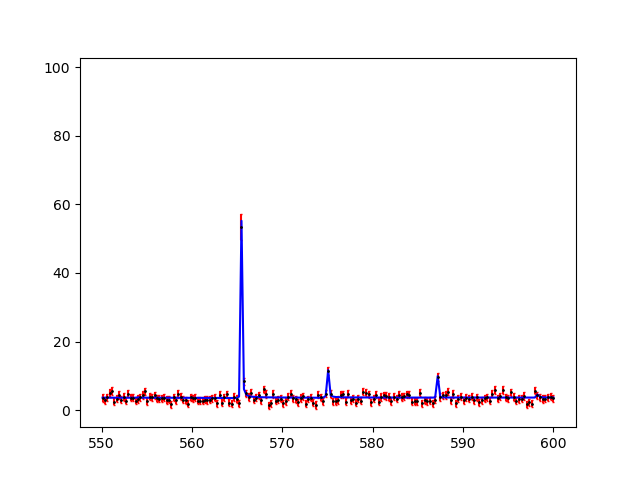

In [10]:
figure()
errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=np.sqrt(np.diag(dc.CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
# plot(dc.pw_exp.E, Resonance_Matrix@lp_unconstrained_w.x+potential_scattering.flatten(), lw=2, color='purple')
# plot(dc.pw_exp.E, Resonance_Matrix@lp_constrained_w.x+potential_scattering.flatten(), lw=2, color='purple')
plot(dc.pw_exp.E, Resonance_Matrix@unconstrained_w+potential_scattering.flatten(), color='blue')
# plot(dc.pw_exp.E, reduced_feature_matrix@unconstrained_w_reduced+potential_scattering.flatten(), color='blue')


# # plot(dc.pw_fine.E, dc.pw_fine.est_unconstrained_xs)
# # plot(dc.pw_fine.E, dc.pw_fine.est_constrained_xs)

ylim([-5, max_xs*1.5])

# figure()
# bins = hist(np.log10(unconstrained_w), bins = 100)

### Now perform bisection method to find a weight constraint for 1-5 resonances

Need to define lower threshold for weight constraint because if there is a blackout resonance, the problem becomes infeasible if the constrained weights don't allow the blackout constraint to be met.




In [11]:
def solve_qp_w_constraint(P, q, G, h, lb, ub, w_constraint, w_threshold=1e-10, verbose_bool = False):
    G_wc = np.vstack([G,np.ones(len(P))])
    h_wc = np.append(h, w_constraint)
    qp_res_c = solve_qp(P, q, G=G_wc, h=h_wc, A=None, b=None, lb=lb, ub=ub, 
                                                        solver="cvxopt",
                                                        verbose=verbose_bool,
                                                        abstol=1e-10,
                                                        reltol=1e-10,
                                                        feastol= 1e-8,
                                                        maxiters = 100) 
    return qp_res_c, np.count_nonzero(qp_res_c>w_threshold)


def get_minimum_weight_factor(unconstrained_weight):
    failed = True
    print(f'Unconstrained weight: {unconstrained_weight}')
    for fac in np.linspace(0,1,50):
        w = unconstrained_weight*fac
        try:
            res, nonzero = solve_qp_w_constraint(P, q, G, h, lb, ub, w)
            failed = False
        except:
            print(f'Failed at weight: {w}')

        if not failed:
            break
        
    return w, nonzero

def secant_method(f, x0, y0, x1, offset, tol=1e-5, n=0):
    # increment counter
    n += 1

    # calculate weights and number of resonances at endpoints
    qp_res, numres = f(x1)
    y1 = numres-offset

    # calculate next root approximation
    xn = x1 - y1 * ((x1 - x0) / (y1 - y0))
    # if nan or inf (bc same y val) divide by non-zero  #TODO: find the best normalization here, 1 works but maybe something else is faster?
    # if np.isnan(xn) or np.isinf(xn):
    #     xn = x1 - y1 * ((x1 - x0) /1)

    # check tolerance condition - could do list comprehension here to get w_constraints corrresponding to multiple different resonances in one go
    if -tol < y1 < tol:
        return xn, n, qp_res
    
    # recursive call with updated interval
    return secant_method(f, x1, y1, xn, offset, tol=tol, n=n)



In [12]:
# iw_keep = np.argwhere(qp_res>w_threshold).flatten()
# new_full_feature_matrix = full_feature_matrix[:, iw_keep]
# y0, y1 = number_of_surviving_resonances(P, q, G, h, 0, w_threshold), number_of_surviving_resonances(P, q, G, h, np.sum(qp_res), w_threshold)

# full_feature_matrix = Resonance_Matrix
# w_threshold = 1e-10
# def func(w):
#     return solve_qp_w_constraint(P, q, G, h, lb, ub, w, w_threshold)[1]-10

# unconstrained_weight = np.sum(unconstrained_w)
# if any(index_0T):
#     min_w, min_nonzero = get_minimum_weight_factor(unconstrained_weight)
# else:
#     min_w = 0; min_nonzero = 0

# unconstrained_weight
# root_approx = bisection_method(func, [min_w, 0.1], 1e-1)
# solve_qp_w_constraint(P, q, G, h, lb, ub, root_approx, w_threshold)

# w_constraint, niter, qp_res = secant_method(func, min_w, min_nonzero-target_numres, unconstrained_weight*0.5, target_numres, tol=1e-2, n=0)
# w_constraint, niter, qp_res = secant_method(func, unconstrained_weight, np.count_nonzero(unconstrained_w>w_threshold)-target_numres, min_w, target_numres, tol=1e-2, n=0)


### Create my own bisection method!

- Scatter shot of w constraints [0, unconstrained_w]
- run in parallel
- Discard points above target number of resonances and below value necessary to meet the blackout resonance constraint
- besect to get new set of w constraints, looking for number of resonances that have not been solved for
- run in parallel
- if w constraint results in duplicate solutions for numres, take the value that is higher weight
- repeat

Also could try to do this with a more traditional biseciton method, rather than dropping an array of points for each iteration I just drop a single point and send it off to a processor for evaluation.

In [13]:
def solve_wcons(ws, maxres, numres_wcon, solution_ws):
    for w in ws:
        try:
            constrained_ws, numres = solve_qp_w_constraint(P, q, G, h, lb, ub, w, w_threshold, verbose_bool=False)
            print(f'{numres} resonance solution found at w={w}')
            solution = True
        except:
            print(f'Failed at weight: {w}')
            solution = False
            if w > numres_wcon[1, 0]:
                numres_wcon[1, 0] =  w

        if solution:
            if numres >= maxres:
                numres_wcon = np.concatenate((numres_wcon,np.array([[numres], [w]])), axis=1)
            else:
                numres_wcon[1, numres] = w
                solution_ws[:, numres] = constrained_ws 
    return numres_wcon, solution_ws

def bisect_and_get_new_wcons(numres_wcon):

    found = numres_wcon[:, numres_wcon[1,:]!=0]
    notfound = numres_wcon[:, numres_wcon[1,:]==0]

    est_indices = np.searchsorted(found[0,:],notfound[0,:])
    ub_search_interval, ub_search_interval_counts = np.unique(found[:,est_indices], return_counts=True, axis=1)

    new_w = np.array([])
    for iub, vub in enumerate(ub_search_interval[1,:]):
        if iub == 0:
            lower = numres_wcon[1,0]
        else:
            lower = ub_search_interval[1, iub-1]
        upper = ub_search_interval[1, iub]
        new_w = np.append(new_w, np.linspace(lower, upper, ub_search_interval_counts[iub]+1, endpoint=False)[1::])

    return new_w


w_threshold = 1e-10
unconstrained_weight = np.sum(unconstrained_w)
unconstrained_res = np.count_nonzero(unconstrained_w>w_threshold)
print(unconstrained_weight)
print(unconstrained_res)

maxres = 5
assert(unconstrained_res>=maxres-1)
initial_ws = np.logspace(-2, np.log10(unconstrained_weight), 5)
numres_wcon = np.array([np.arange(maxres), np.zeros(maxres)])
solution_ws = np.zeros((nfeatures, maxres))

print(initial_ws)
print(numres_wcon)

delta_threshold = 1e-3
searching = True
iterations = 0
numres_wcon, solution_ws = solve_wcons(initial_ws, maxres, numres_wcon,solution_ws)

colors = ['cornflowerblue', 'blue', 'mediumpurple', 'indigo', 'pink']
while searching:

    new_w = bisect_and_get_new_wcons(numres_wcon)
    # could also just bisect once, recursively splitting the problem
    
    # figure()
    # scatter(numres_wcon[1,:], numres_wcon[0,:], color=colors[iterations])
    # # scatter([numres_wcon[1,0]], [0], color=colors[iterations])
    # ylabel('# Res'); xlabel('w constraint')
    # for each in new_w:
    #     axvline(each, color=colors[iterations])
    # savefig(f'bisection_{iterations}.png')
    
    numres_wcon, solution_ws = solve_wcons(new_w, maxres, numres_wcon,solution_ws)

    # check for threshold between failed and successful cases
    iRes_nosol = (np.argwhere(numres_wcon[1,:] == 0).flatten())
    failed_success_diff = numres_wcon[1,0] - numres_wcon[1,max(iRes_nosol)+1]
    if abs(failed_success_diff) < delta_threshold:
        numres_wcon[1,0:max(iRes_nosol)+1] = np.nan
        searching = False

    
    iterations += 1


0.0630541331841832
5
[0.01       0.01584632 0.02511058 0.03979103 0.06305413]
[[0. 1. 2. 3. 4.]
 [0. 0. 0. 0. 0.]]
2 resonance solution found at w=0.01
2 resonance solution found at w=0.015846318837180177
3 resonance solution found at w=0.025110582068957145
3 resonance solution found at w=0.03979102896518746
8 resonance solution found at w=0.06305413318418321
2 resonance solution found at w=0.005282106279060059
2 resonance solution found at w=0.010564212558120118
3 resonance solution found at w=0.0394502260106817
2 resonance solution found at w=0.0035214041860400394
2 resonance solution found at w=0.007042808372080079
3 resonance solution found at w=0.036809172871151666
2 resonance solution found at w=0.0023476027906933596
2 resonance solution found at w=0.004695205581386719
3 resonance solution found at w=0.03504847077813164
1 resonance solution found at w=0.0015650685271289065
2 resonance solution found at w=0.003130137054257813
3 resonance solution found at w=0.03387466938278497
1 r

## Solve unconstrained problem with reduced feature matrix

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


(-5.0, 102.84601255072708)

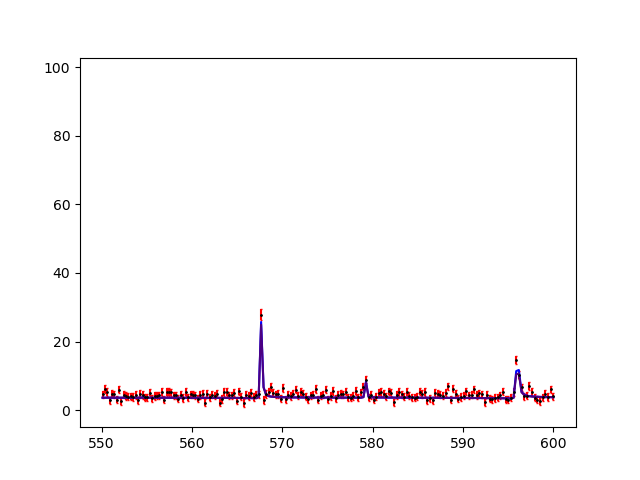

In [238]:
# for each in numres_wcon != nan

ires = 4
wcon = numres_wcon[1,ires]
constrained_res = solution_ws[:,ires]
# constrained_res, _ = solve_qp_w_constraint(P, q, G, h, lb, ub, wcon, w_threshold, verbose_bool=False)

### reduce feature bank
full_feature_matrix = Resonance_Matrix
index_w_surviving = np.argwhere(constrained_res>w_threshold).flatten()
reduced_feature_matrix = full_feature_matrix[:, index_w_surviving]

P_reduced, q_reduced, G_reduced, h_reduced, lb_reduced, ub_reduced, index_0T_reduced = fn.get_qp_inputs(np.array(dc.pw_exp.exp_xs), 
                                                                                     np.array(dc.CovXS), potential_scattering.flatten(), 
                                                                                     max_xs, reduced_feature_matrix )

unconstrained_w_reduced = solve_qp(P_reduced, q_reduced, G=G_reduced, h=h_reduced, A=None, b=None, lb=lb_reduced, ub=ub_reduced, 
                                                                                                solver="cvxopt",
                                                                                                verbose=False,
                                                                                                abstol=1e-12,
                                                                                                reltol=1e-12,
                                                                                                feastol= 1e-8,
                                                                                                maxiters = 100)
# dc.add_estimate(est_resladder, est_name='est_unconstrained')

figure()

errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=np.sqrt(np.diag(dc.CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
plot(dc.pw_exp.E, reduced_feature_matrix@unconstrained_w_reduced+potential_scattering.flatten(), color='blue')
plot(dc.pw_exp.E, full_feature_matrix@constrained_res+potential_scattering.flatten(), color='indigo')
# plot(dc.pw_fine.E, dc.pw_fine.theo_xs, 'g')
# plot(dc.pw_fine.E, dc.pw_fine.est_unconstrained_xs)

scatter(np.array(dc.pw_exp.E)[index_0T], np.ones(len(index_0T))*10)
ylim([-5, max_xs*1.5])

In [ ]:
### fine grid weight versus constraint
# x_constrained = []

# for fac in np.linspace(0,0.6,200):
#     G_wc = np.vstack([G,np.ones(len(unconstrained_w))])
#     h_wc = np.append(h, unconstrained_weight*fac)
#     res = solve_qp(P, q, G=G_wc, h=h_wc, A=None, b=None, lb=lb, ub=ub, 
#                                                         solver="cvxopt",
#                                                         verbose=False,
#                                                         abstol=1e-10,
#                                                         reltol=1e-10,
#                                                         feastol= 1e-8,
#                                                         maxiters = 500)
#     x_constrained.append(res)

# x_constrained = np.load('ws_vs_wconstraint.npy')
# x_nonzero = []
# for each in x_constrained:
#     try:
#         non0 = np.count_nonzero(each>w_threshold)
#     except:
#         non0 = np.nan
#     x_nonzero.append(non0)

# figure()
# plot(np.linspace(0,0.6,200), x_nonzero, '.')

In [ ]:
# # constrained_res, nonzero = solve_qp_w_constraint(P, q, G, h, lb, ub, min_w*1.2, w_threshold)
# constrained_res, nonzero = solve_qp_w_constraint(P, q, G, h, lb, ub, w_constraint, w_threshold)
# print(nonzero)

In [ ]:
# est_resladder = fn.get_resonance_ladder_from_feature_bank(constrained_res, Elam_features, Gtot_features, w_threshold)
# dc.add_estimate(est_resladder)

# figure()

# errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=np.sqrt(np.diag(dc.CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
# # plot(dc.pw_exp.E, Resonance_Matrix@lp_res.x+potential_scattering.flatten(), lw=2, color='purple')
# # plot(dc.pw_exp.E, Resonance_Matrix@constrained_res+potential_scattering.flatten(), color='blue')
# plot(dc.pw_fine.E, dc.pw_fine.theo_xs, 'g')
# plot(dc.pw_fine.E, dc.pw_fine.est_xs, 'b')

# scatter(np.array(dc.pw_exp.E)[index_0T], np.ones(len(index_0T))* max_xs)
# ylim([-5, max_xs*1.5])